## Bank Marketing Campaign

---------------------------------------------------------------------------------------------------------------------------

This is a classification problem related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. I have used the following classification models, to see how these models will perform on this dataset:

1. Logistic Regression
2. K-Nearest Neighbours
3. Support Vector Machine
4. Decision Tree Classifier
5. Random Forest Classifier
6. Gradient Boosted Machine

---------------------------------------------------------------------------------------------------------------------------

### Feature Definitions
1. age: (numeric)
2. job: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3. marital: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education: (categorical: primary, secondary, tertiary and unknown)
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. balance: Balance of the individual.
9. contact: contact communication type (categorical: 'cellular','telephone')
10. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
11. day: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
12. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no') See Feature importance plot for further diagnosis. 
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
17. y: has the client subscribed a term deposit? (binary: 'yes','no')

---------------------------------------------------------------------------------------------------------------------------

### NB
In order to see the EDA of this project, please click on my [Streamlit Web Application](https://streamlit-classification.herokuapp.com/), to see a full report of the EDA and model performance prepared for this project.

---------------------------------------------------------------------------------------------------------------------------


## Table of Contents:
* [Importing Libraries](#one)
    * [Importing Dataset](#one-one)
    * [View Stastical Details](#one-two)
    * [Missing Values](#one-three)
* [Create New Features](#two)
* [Feature Engineering](#three)
    * [Correlation Analysis](#three-one)
    * [Pipeline Strategy](#three-two)
    * [Categorical Encoding](#three-three)
* [Feature Selection](#four)
* [Train-Test-Split](#five)
    * [Oversampling Training Set](#five-one)
* [Hyper-parameter Optimisation](#six)
* [OOT Data Prediction](#seven)
* [Model Diagnosis](#eight)
    * [Confusion Matrix](#eight-one)
    * [ROC-AUC Curve](#eight-two)
    * [Feature Importance](#eight-three)
    * [Actual vs Predicted](#eight-four)

This dataset was derived from UCI Machine Learning Repository <a href="https://archive.ics.uci.edu/ml/datasets/Bank+Marketing" target="_blank"> (Click Here) </a>.

## ----------------------------------------------------------------------------------------------------------------------------------

## Importing the libraries <a class="anchor" id="one"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for the model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Classifier Libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import optuna
import json
import os

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder
from imblearn.over_sampling import SMOTE
from featurewiz import featurewiz

pd.set_option('display.max_columns', None)

Imported featurewiz: advanced feature engg and selection library. Version=0.0.42
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


### Importing the dataset <a class="anchor" id="one-one"></a>

In [2]:
dataset = pd.read_csv('bank.csv', sep=';')
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
dataset.shape ## There are 4521 instances and 17 attributes

(4521, 17)

### View statistical details <a class="anchor" id="one-two"></a>
The mean details in this dataset suggests that:

- The average age is around 40
- The average annual balance is €1423
- The last contact day of the month is 16 days
- The last contact duration was 264 seconds
- The number of contacts performed during this campaign and for this client is 3
- The number of days that passed by after the client was last contacted from a previous campaign is 40 days
- The number of contacts performed before this campaign and for this client is 1

In [4]:
dataset.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


### Check for missing values <a class="anchor" id="one-three"></a>

No missing values present

In [6]:
dataset.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [7]:
dataset.pdays.unique()

array([ -1, 339, 330, 176, 147, 241, 152, 105, 342, 101,   5,  92,  56,
       170, 182, 297, 196, 460, 137, 367, 145, 169, 207, 266, 288, 168,
       345, 436,  90, 183, 146, 335, 347, 119,   7, 271, 181,  88, 141,
       126,  61, 373, 351, 242,  62,  91, 308, 250, 172, 265,  78,  28,
        79,   1, 188, 167,  89, 164, 462, 209, 321, 254,  94, 364,  96,
       356, 149, 363, 275, 325, 341, 260, 358,  87, 303,  98, 327, 337,
       322, 102,  99, 370,  84, 212,  63,  81, 191, 360, 332,  80,  85,
       247, 150, 175, 382, 261, 336,  58, 206, 112, 199, 133, 208, 253,
       135, 278, 140, 298, 273, 124, 281, 162, 323, 349, 117,   2, 256,
       333, 116, 268, 136, 198, 357, 259, 353, 174, 371, 205, 246,  69,
       315, 110, 461, 184, 270, 127, 187,  64, 130, 346, 100, 352, 808,
       113, 378, 292, 287, 107, 293, 139, 138, 193, 274,  97, 103, 359,
       185, 674, 211, 300, 334, 280, 479,  95, 262, 362, 225,   3, 366,
        60, 190, 368, 122, 343, 131, 365, 299, 115, 316, 180, 15

## Create new features <a class="anchor" id="two"></a>


We need to create random variables in this case study. When we perform automated feature selection, we can use these random variables as a threshold, to analyse the variable imporance.

In [8]:
seed = np.random.RandomState(1234)

dataset['random_binary'] = seed.choice([0,1], dataset.shape[0])
dataset['random_continuous'] = seed.uniform(0,1, dataset.shape[0])
dataset['random_integer'] = seed.randint(1,10, dataset.shape[0])
dataset['random_normal'] = seed.normal(0,1, dataset.shape[0])

In [9]:
target = ['y']
month = ['month']

vars_selected = [var for var in dataset.columns]

data_select = dataset[vars_selected]

print(f'We selected {len(vars_selected) - len(target)} variables for the pipeline')
print(f'We selected {len([var for var in vars_selected if var in target])} target variables for the pipeline')
print(data_select.shape)

We selected 20 variables for the pipeline
We selected 1 target variables for the pipeline
(4521, 21)


In [10]:
# make list of variables types
dates = ['month']
info = ['pdays', 'campaign']
# numerical: discrete and continuous
discrete = [var for var in data_select.columns if data_select[var].dtype != 'O' and var not in info and dataset[var].nunique() <= 10 and var not in dates and var not in target]

continuous = [var for var in data_select.columns if data_select[var].dtype != 'O' and var not in info and var not in discrete and var not in dates and var not in target]

# High cardinality
high = [var for var in data_select.columns if data_select[var].dtype=='O' and var not in info and data_select[var].nunique()>10 and var not in dates and var not in target]

#Few missing values 
few_miss = [ var for var in data_select.columns if data_select[var].isnull().sum() < 0.005 * data_select.shape[0] and data_select[var].isnull().sum() != 0 and var in continuous]

#Big missing values 
big_miss = [ var for var in data_select.columns if data_select[var].isnull().sum() >= 0.005 * data_select.shape[0] and data_select[var].isnull().sum() != 0 and var in continuous]

# categorical
categorical = [var for var in data_select.columns if data_select[var].dtype == 'O' and var not in info and var not in dates and var not in high ]
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} high cardinality variables'.format(len(high)))
print('There are {} few miss '.format(len(few_miss)))
print('There are {} big miss'.format(len(big_miss)))
print('There are {} categorical variables'.format(len(categorical)))

There are 2 discrete variables
There are 7 continuous variables
There are 1 high cardinality variables
There are 0 few miss 
There are 0 big miss
There are 8 categorical variables


<AxesSubplot:>

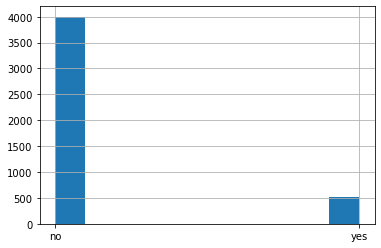

In [11]:
data_select.y.hist()

In [12]:
# The classes are heavily skewed we need to solve this issue later.
print(f"No Subscription: {round(data_select['y'].value_counts()[0]/len(data_select) * 100,2)} % of the dataset")
print(f"Subscription: {round(data_select['y'].value_counts()[1]/len(data_select) * 100,2)} % of the dataset")

No Subscription: 88.48 % of the dataset
Subscription: 11.52 % of the dataset


## Feature Enginerering <a class="anchor" id="three"></a>


In [13]:
print(high)

data_select.job.unique()

['job']


array(['unemployed', 'services', 'management', 'blue-collar',
       'self-employed', 'technician', 'entrepreneur', 'admin.', 'student',
       'housemaid', 'retired', 'unknown'], dtype=object)

In [14]:
X_train = data_select
print(X_train.shape)

X_train.head()

(4521, 21)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,random_binary,random_continuous,random_integer,random_normal
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no,1,0.483045,4,-0.119157
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no,1,0.917188,9,0.953200
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no,0,0.943261,9,0.814835
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no,1,0.137987,7,1.129793
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no,0,0.963380,4,-1.906638


### Correlation Analysis <a class="anchor" id="three-one"></a>


In [15]:
import scipy.stats as ss

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def correlation(df, threshold):
    col_corr = dict()
    corr_matrix = df.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                col_name = corr_matrix.columns[i]
                col_corr.update({col_name:f'{corr_matrix.columns[j]}'})
                
    for key, value in col_corr.items():
        
        if df[key].dtype == object:
            confusion_matrix = pd.crosstab(df[key], df[value])
            if abs(confusion_matrix.values).all() < threshold:
                print(f'{key} {value} = {cramers_corrected_stat(confusion_matrix.values)}')
                
        else:
            print(f'{key} correlates with {value}')
            
            
def rename_rare_features(df, var):
    transformedd_var = {}
    
    for i in var:
        if "Rare" in df[i].unique():
            transformedd_var.update({i:i+"_Rare"})
            
            print(f'{i} has rare values besides: {[rare for rare in df[i].unique() if "Rare" not in rare]}')
            
    return transformedd_var

In [16]:
test_df = X_train
correlation(test_df, 0.5)

previous correlates with pdays


### Pipeline strategy for high cardinality variables <a class="anchor" id="three-two"></a>


In [17]:
pipeline = Pipeline([
    ('imputer_car_rare', RareLabelEncoder(tol = 0.03, variables=high, n_categories=5))
])

In [18]:
X_train_transformed = pipeline.fit_transform(X_train)
X_train_transformed.job.unique()

array(['Rare', 'services', 'management', 'blue-collar', 'self-employed',
       'technician', 'entrepreneur', 'admin.', 'retired'], dtype=object)

In [19]:
X_train_transformed

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,random_binary,random_continuous,random_integer,random_normal
0,30,Rare,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no,1,0.483045,4,-0.119157
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no,1,0.917188,9,0.953200
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no,0,0.943261,9,0.814835
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no,1,0.137987,7,1.129793
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no,0,0.963380,4,-1.906638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no,0,0.172312,8,-0.026918
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no,0,0.362865,3,1.013547
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no,1,0.234776,8,0.148010
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no,1,0.745968,8,1.232112


In [20]:
rename_rare_features(X_train_transformed, high)

job has rare values besides: ['services', 'management', 'blue-collar', 'self-employed', 'technician', 'entrepreneur', 'admin.', 'retired']


{'job': 'job_Rare'}

### Encoding Categorical Variables <a class="anchor" id="three-three"></a>


In [21]:
X_train_transformed["default"] = X_train_transformed["default"].map({"no":0,"yes":1})

X_train_transformed["housing"] = X_train_transformed["housing"].map({"no":0,"yes":1})

X_train_transformed["loan"] = X_train_transformed["loan"].map({"no":0,"yes":1})

X_train_transformed["y"] = X_train_transformed["y"].map({"no":0,"yes":1})

X_train_transformed.education = X_train_transformed.education.map({"primary": 0, "secondary":1, "tertiary":2})

X_train_transformed.month = pd.to_datetime(X_train_transformed.month, format = "%b").dt.month

In [22]:
X_train_transformed

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,random_binary,random_continuous,random_integer,random_normal
0,30,Rare,married,0.0,0,1787,0,0,cellular,19,10,79,1,-1,0,unknown,0,1,0.483045,4,-0.119157
1,33,services,married,1.0,0,4789,1,1,cellular,11,5,220,1,339,4,failure,0,1,0.917188,9,0.953200
2,35,management,single,2.0,0,1350,1,0,cellular,16,4,185,1,330,1,failure,0,0,0.943261,9,0.814835
3,30,management,married,2.0,0,1476,1,1,unknown,3,6,199,4,-1,0,unknown,0,1,0.137987,7,1.129793
4,59,blue-collar,married,1.0,0,0,1,0,unknown,5,5,226,1,-1,0,unknown,0,0,0.963380,4,-1.906638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,1.0,0,-333,1,0,cellular,30,7,329,5,-1,0,unknown,0,0,0.172312,8,-0.026918
4517,57,self-employed,married,2.0,1,-3313,1,1,unknown,9,5,153,1,-1,0,unknown,0,0,0.362865,3,1.013547
4518,57,technician,married,1.0,0,295,0,0,cellular,19,8,151,11,-1,0,unknown,0,1,0.234776,8,0.148010
4519,28,blue-collar,married,1.0,0,1137,0,0,cellular,6,2,129,4,211,3,other,0,1,0.745968,8,1.232112


In [23]:
X_train_transformed.drop(["poutcome", "contact"], axis = 1, inplace = True)
X_train_transformed.dropna(inplace = True)

## Feature Selection <a class="anchor" id="four"></a>


Feature Selection is essential for model building. **Featurewiz** is a library that finds the best features in the dataset. It composes of two methods:

1. __SULOV__ algorithm finds a pair of highly correlated variables that exceeds a correlation threshold (in this case, 90%). Then finds variables that have a high mutual information score that maps to the target variable and ignores the highly correlated variables. <br> <br>
2. The __Recursive XGBoost__ algorithm follows after SULOV selecting variables with high mutual information scores with most minor correlations. This algorithm takes a subset of variables and finds the top N features, which repeat five times with different variables after each iteration.  Finally, we combine all variables from those five iterations and remove all the duplicated features—results with the best variables in the dataset.


In [24]:
features, train = featurewiz(X_train_transformed, target, corr_limit=0.9, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")


print(features)

Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
Loading train data...
Shape of your Data Set loaded: (4334, 19)
Loading test data...
    Filename is an empty string or file not able to be loaded
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    18 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
No GPU active on this device
    Running XGBoost using CPU parameters
Removing 0 columns from further processing since ID or low information variables
    columns removed: []
    After removing redundant variables from further processing, features left = 18
#### Single_Label Binary_Classification Feature Selection Started ####
Searching for highly correlated variables from 16 variables using SULOV method
#####  SULOV : Searching for Uncorrelated List Of Variables (takes time...

In [25]:
feature_list = ['duration', 'housing', 'previous', 'month', 'pdays', 'loan', 'age', 'day', 'balance', 'marital']
feature_target = 'y'

train_feature_selection = train[feature_list]

X = train_feature_selection
 
y = train.y.values

X_scaled =  StandardScaler().fit_transform(X)

## Splitting Dataset into Train and Test <a class="anchor" id="five"></a>


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size = 0.2, random_state = 123, stratify=y)

### Oversampling Data for Training<a class="anchor" id="five-one"></a>

As seen above, our targets are highly imbalanced. A problem with ___imbalanced classification___ is that too few examples of the minority class for a model to learn the decision boundary effectively. Although our dataset is small, one way to solve this problem is to oversample the examples in the minority class. Oversampling can be achieved by simply duplicating examples from the minority class in the training dataset before fitting a model. As a result, we balance the class distribution but do not provide additional information to the model.

We will use __SMOTE__ technique to approach our oversampling solution. SMOTE works by selecting close examples in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [27]:
smt = SMOTE(random_state=1234)


X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
np.bincount(y_train_sm)
X_train_sm.shape, y_train_sm.shape

((6130, 10), (6130,))

In [30]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "Gradient Boosted Machine": GradientBoostingClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(probability=True),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}



for key, classifier in classifiers.items():
    classifier.fit(X_train_sm, y_train_sm)
    training_score = cross_val_score(classifier, X_train_sm, y_train_sm, cv=5)
    print("Classifiers: ", key, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisiticRegression Has a training score of 77.0 % accuracy score
Classifiers:  Gradient Boosted Machine Has a training score of 89.0 % accuracy score
Classifiers:  Random Forest Classifier Has a training score of 94.0 % accuracy score
Classifiers:  KNearest Has a training score of 91.0 % accuracy score
Classifiers:  Support Vector Classifier Has a training score of 86.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 89.0 % accuracy score


## Hyper-parameter Optimisation <a class="anchor" id="six"></a>

In [32]:
def objective(trial):
    
    predictors = X_train_sm
    target = y_train_sm
    
    classifier_name = trial.suggest_categorical("classifier", ["LogReg", "GBM", "DT", "SVM", "RandomForest", "KNN"])
    
    if classifier_name == "LogReg":
        
        penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
        if penalty == 'l1':
            solver = 'saga'
        else:
            solver = 'lbfgs'
        regularization = trial.suggest_uniform('logistic-regularization', 0.01, 10)
        max_iter = trial.suggest_int('max_iter', 100, 500)
        model = LogisticRegression(penalty=penalty, C=regularization, solver=solver, max_iter=max_iter)
        model.fit(predictors, target)
        
    if classifier_name == "GBM":
        subsample = trial.suggest_discrete_uniform("subsample", 0.1, 1.0, 0.1)
        model = GradientBoostingClassifier(subsample=subsample, validation_fraction=0.2, n_iter_no_change=5, tol=0.01, random_state=0)
        model.fit(predictors, target)
        
    if classifier_name == 'DT':
        max_depth = trial.suggest_int('max_depth', 5, X_train.shape[1])
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        model.fit(predictors, target)
        
    if classifier_name == 'SVM':
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
        degree = trial.suggest_discrete_uniform('degree', 1, 5, 1)
        model = SVC(kernel=kernel, C=regularization, degree=degree)
        model.fit(predictors, target)
        
    if classifier_name == "RandomForest":
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        rf_bootstrap = trial.suggest_categorical("rf_bootstrap", [True, False])
        model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators, bootstrap=rf_bootstrap, n_jobs=-1)
        model.fit(predictors, target)
        
    if classifier_name == "KNN":
        optimizer = trial.suggest_categorical('algorithm', ['auto','ball_tree','kd_tree','brute'])
        knn_max_depth = trial.suggest_int("k_n_neighbors", 2, 10, log=True)
        model = KNeighborsClassifier(n_neighbors=knn_max_depth,algorithm=optimizer)
        model.fit(predictors, target)
        
    if trial.should_prune():
        raise optuna.TrialPruned()
        
    score = cross_val_score(model, predictors, target, n_jobs=-1, cv=5)
    #accuracy = model.score(predictors, target)
    accuracy = score.mean()
    return accuracy

sampler = optuna.samplers.TPESampler(seed=1234)
study = optuna.create_study(study_name="best", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

    
     

[I 2021-09-03 10:10:22,924] A new study created in memory with name: best
[I 2021-09-03 10:10:29,780] Trial 0 finished with value: 0.8796084828711255 and parameters: {'classifier': 'SVM', 'kernel': 'rbf', 'svm-regularization': 3.584594526879088, 'degree': 3.0}. Best is trial 0 with value: 0.8796084828711255.
[I 2021-09-03 10:10:33,052] Trial 1 finished with value: 0.8827079934747145 and parameters: {'classifier': 'GBM', 'subsample': 0.8}. Best is trial 1 with value: 0.8827079934747145.
[I 2021-09-03 10:10:33,340] Trial 2 finished with value: 0.9055464926590538 and parameters: {'classifier': 'KNN', 'algorithm': 'kd_tree', 'k_n_neighbors': 5}. Best is trial 2 with value: 0.9055464926590538.
[I 2021-09-03 10:10:33,450] Trial 3 finished with value: 0.7701468189233278 and parameters: {'classifier': 'LogReg', 'penalty': 'l1', 'logistic-regularization': 4.4269861464877245, 'max_iter': 464}. Best is trial 2 with value: 0.9055464926590538.
[I 2021-09-03 10:10:37,901] Trial 4 finished with value

In [33]:
best_trial = [study.best_trial]
study.best_trial

FrozenTrial(number=19, values=[0.9458401305057096], datetime_start=datetime.datetime(2021, 9, 3, 10, 11, 30, 536704), datetime_complete=datetime.datetime(2021, 9, 3, 10, 11, 42, 226450), params={'classifier': 'RandomForest', 'rf_n_estimators': 649, 'rf_max_depth': 31, 'rf_bootstrap': False}, distributions={'classifier': CategoricalDistribution(choices=('LogReg', 'GBM', 'DT', 'SVM', 'RandomForest', 'KNN')), 'rf_n_estimators': IntUniformDistribution(high=1000, low=10, step=1), 'rf_max_depth': IntLogUniformDistribution(high=32, low=2, step=1), 'rf_bootstrap': CategoricalDistribution(choices=(True, False))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=19, state=TrialState.COMPLETE, value=None)

##### As we can see here Random Forest with n_estimators as 520 and max_depth of 29 works best for this dataset. We will use this model, along with Logistic Regression and GBM further in the notebook, to compare metrics.

In [34]:
current_dir = os.getcwd()

get_item = best_trial[0].params.items()
for key, value in get_item:
    
    trial_map = dict((key, value) for (key, value) in get_item)
    trial_map.update({'Training set score after cv (5): ' : best_trial[0].values })
    break
    

## Save the best parameters into a json file
with open(current_dir + '/model_hyper-parameter.json', 'w') as fp:
    json.dump(trial_map, fp)
    
print(trial_map)

{'classifier': 'RandomForest', 'rf_n_estimators': 649, 'rf_max_depth': 31, 'rf_bootstrap': False, 'Training set score after cv (5): ': [0.9458401305057096]}


In [36]:
with open ('./model_hyper-parameter.json', 'r') as fp:
    hyperparameters = json.load(fp)

In [37]:
#Train the Random Forest Classifier with the proposed parameters
rf_hyperparam_train = RandomForestClassifier(n_estimators=hyperparameters['rf_n_estimators'], 
                                             max_depth=hyperparameters['rf_max_depth'],
                                             bootstrap=hyperparameters['rf_bootstrap'])
rf_hyperparam_train.fit(X_train_sm, y_train_sm)

training_score = cross_val_score(rf_hyperparam_train, X_train_sm, y_train_sm, cv=5)
print("Random Forest Classifier has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Random Forest Classifier has a training score of 94.0 % accuracy score


### ROC-AUC Score of the Training set after CV

In [38]:
log_reg_pred = cross_val_predict(classifiers['LogisiticRegression'], X_train_sm, y_train_sm, cv=5)
gbm_pred = cross_val_predict(classifiers['Gradient Boosted Machine'], X_train_sm, y_train_sm, cv=5)
knears_pred = cross_val_predict(classifiers['KNearest'], X_train_sm, y_train_sm, cv=5)
svc_pred = cross_val_predict(classifiers['Support Vector Classifier'], X_train_sm, y_train_sm, cv=5)
dt_pred = cross_val_predict(classifiers['DecisionTreeClassifier'], X_train_sm, y_train_sm, cv=5)
rf_pred = cross_val_predict(rf_hyperparam_train, X_train_sm, y_train_sm, cv=5)

print('Logistic Regression: ', roc_auc_score(y_train_sm, log_reg_pred))
print('Gradient Boosted Machine: ', roc_auc_score(y_train_sm, gbm_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train_sm, rf_pred))
print('KNears Neighbors: ', roc_auc_score(y_train_sm, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train_sm, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train_sm, dt_pred))

Logistic Regression:  0.7699836867862968
Gradient Boosted Machine:  0.8929853181076672
Random Forest Classifier:  0.9455138662316477
KNears Neighbors:  0.905546492659054
Support Vector Classifier:  0.8587275693311582
Decision Tree Classifier:  0.8879282218597063


## Predicting the Test set results <a class="anchor" id="seven"></a>

In [39]:
lr_y_pred = classifiers['LogisiticRegression'].predict_proba(X_test)[:,1]
gbm_y_pred = classifiers['Gradient Boosted Machine'].predict_proba(X_test)[:,1]
kn_y_pred = classifiers['KNearest'].predict_proba(X_test)[:,1]
svm_y_pred = classifiers['Support Vector Classifier'].predict_proba(X_test)[:,1]
dt_y_pred = classifiers['DecisionTreeClassifier'].predict_proba(X_test)[:,1]
rf_y_pred = rf_hyperparam_train.predict_proba(X_test)[:,1]

lr_auc = np.round(roc_auc_score(y_test, lr_y_pred).mean(), 4) * 100
gbm_auc = np.round(roc_auc_score(y_test, gbm_y_pred).mean(), 4) * 100
kn_auc = np.round(roc_auc_score(y_test, kn_y_pred).mean(), 4) * 100
svm_auc = np.round(roc_auc_score(y_test, svm_y_pred).mean(), 4) * 100
dt_auc = np.round(roc_auc_score(y_test, dt_y_pred).mean(), 4) * 100
rf_auc = np.round(roc_auc_score(y_test, rf_y_pred).mean(), 4) * 100
print(f"Classifiers: LogisiticRegression has a test mean auc score of, {lr_auc}%")
print(f"Classifiers: Gradient Boosted Machine has a test mean auc score of, {gbm_auc}%")
print(f"Classifiers: KNearest has a test mean auc score of, {kn_auc}%")
print(f"Classifiers: Support Vector Classifier has a test mean auc score of, {svm_auc}%")
print(f"Classifiers: DecisionTreeClassifier has a test mean auc score of, {dt_auc}%")
print(f'Classifiers: Random Forest Classifier has a test mean auc score of {rf_auc}%')

Classifiers: LogisiticRegression has a test mean auc score of, 84.95%
Classifiers: Gradient Boosted Machine has a test mean auc score of, 89.89%
Classifiers: KNearest has a test mean auc score of, 78.81%
Classifiers: Support Vector Classifier has a test mean auc score of, 85.22%
Classifiers: DecisionTreeClassifier has a test mean auc score of, 70.7%
Classifiers: Random Forest Classifier has a test mean auc score of 90.36%


## Model Diagnosis <a class="anchor" id="eight"></a>

### Confusion Matrix <a class="anchor" id="eight-one"></a>


In [40]:
def confusion_matrix(data,actual_values, model):
    pred_values = model.predict_proba(data)[:,1] ##predict the values using model
    bins = np.array([0,0.5,1]) ## specify bins
    cm = np.histogram2d(actual_values, pred_values, bins = bins)[0] ## if values are between 0 and 0.5, they will be considered 1. IF values are between 0.5 and 1, they will be considered 1
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    return cm, accuracy

cm = confusion_matrix(X_test,y_test,rf_hyperparam_train)
cm

cm_df = pd.DataFrame(cm[0])
cm_df.columns = ["Predicted 0", "Predicted 1"]
cm_df = cm_df.rename(index={0:"Actual 0", 1: "Actual 1"})
cm_df

,Predicted 0,Predicted 1
Actual 0,709.0,58.0
Actual 1,50.0,50.0


In [41]:
print (f"Missclassification rate {np.round((50+58)/867, 2)*100}% ")

Missclassification rate 12.0% 


### ROC-AUC Curve<a class="anchor" id="eight-two"></a>

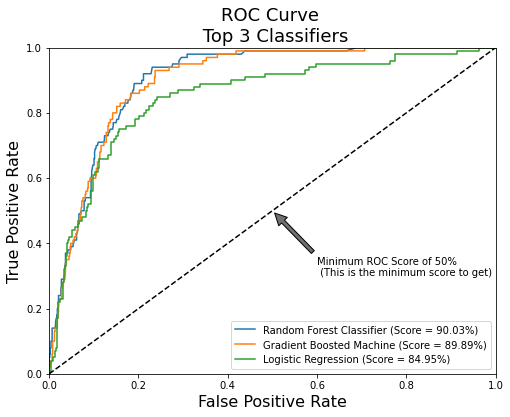

In [42]:
def graph_roc_curve_multiple(rf_fpr, rf_tpr, gbm_fpr, gbm_tpr, lr_fpr, lr_tpr):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (Score = 90.03%)')
    plt.plot(gbm_fpr, gbm_tpr, label='Gradient Boosted Machine (Score = 89.89%)')
    plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (Score = 84.95%)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
rf_fpr, rf_tpr, thresold = roc_curve(y_test, rf_y_pred)
gbm_fpr, gbm_tpr, gbm_threshold = roc_curve(y_test, gbm_y_pred)
lr_fpr, lr_tpr, lr_threshold = roc_curve(y_test, lr_y_pred)

graph_roc_curve_multiple(rf_fpr, rf_tpr, gbm_fpr, gbm_tpr, lr_fpr, lr_tpr)

### Feature Importance<a class="anchor" id="eight-three"></a>

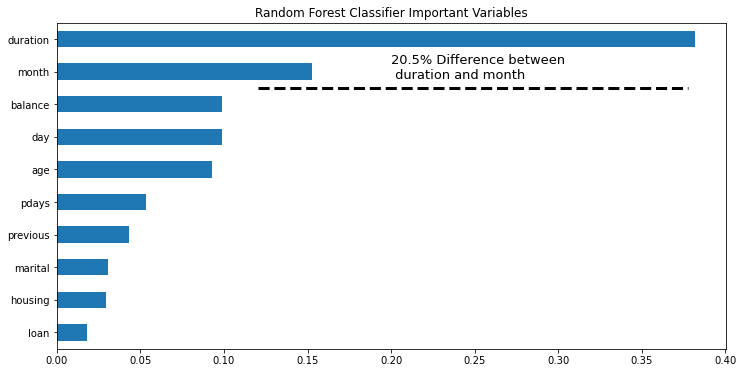

In [55]:
importance = pd.Series(rf_hyperparam_train.feature_importances_)
importance.index = train_feature_selection.columns
importance.sort_values(inplace=True, ascending=True)
importance.plot.barh(figsize=(12,6))
plt.title("Random Forest Classifier Important Variables")
plt.axhline(y=7.50, xmin=0.30, xmax=0.942, color='k', linewidth=3, linestyle='--')
plt.text(0.20, 7.8, '20.5% Difference between \n duration and month', color='k', fontsize=13)

plt.show()

### Distplot Distribution of predictions of actual vs predicted<a class="anchor" id="eight-four"></a>

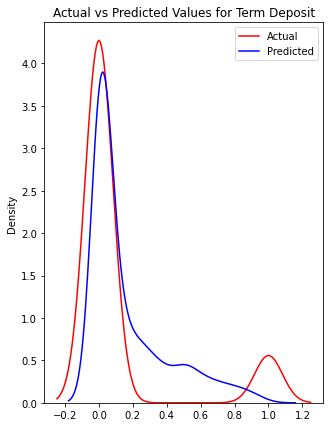

In [56]:
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual")
sns.distplot(rf_y_pred, hist=False, color="b", label="Predicted" , ax=ax)

plt.title('Actual vs Predicted Values for Term Deposit')

plt.legend()
plt.show()